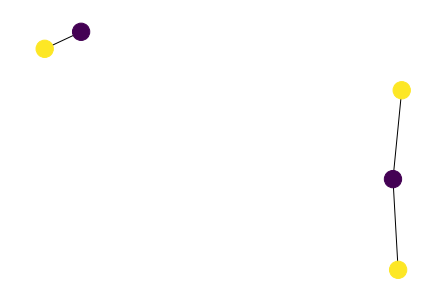

In [71]:
import pandas as pd
import networkx as nx
import xxhash
from matplotlib import pyplot as plt

h = xxhash.xxh64()


class rp:
    def new_collection():
        return Collection()


class Collection:
    def __init__(self) -> None:
        self.dataframes = []
        self.relations = []
        self.df_map = {}
    
    def hash_dataframe(self, dataframe):
        h.update(pd.util.hash_pandas_object(dataframe).values)
        res = h.intdigest()
        h.reset()
        return res
    
    def get_index_of_dataframe(self, dataframe):
        return self.df_map[self.hash_dataframe(dataframe)]
    
    def register_dataframes(self, dataframelist):
        self.dataframes = dataframelist
        for i, entry in enumerate(self.dataframes):
            self.df_map[self.hash_dataframe(entry)] = i

    def register_relations(self, relationlist):
        for source, target, source_column, target_column in relationlist:
            assert self.hash_dataframe(source) in self.df_map
            assert self.hash_dataframe(target) in self.df_map
            assert source_column in source
            assert target_column in target
            self.relations.append([
                self.get_index_of_dataframe(source),
                self.get_index_of_dataframe(target),
                source_column,
                target_column])
    
    def visualize(self):
        node_color = []
        F = nx.Graph()
        for i, dataframe in enumerate(self.dataframes):
            for index, row in dataframe.iterrows():
                F.add_node(str(i) + "_" + str(index))
                node_color.append(i)

        for ind_s, ind_t, source_column, target_column in self.relations:
            s = self.dataframes[ind_s]
            t = self.dataframes[ind_t]
            res = s.reset_index().merge(t.reset_index(), left_on=source_column, right_on=target_column)[["index_x", "index_y", source_column, target_column]]
            for index, row in res.iterrows():
                F.add_edge(str(ind_s) + "_" + str(row[0]), str(ind_t) + "_" + str(row[1]))
        
        nx.draw(F, node_color=node_color)
        plt.draw()
        return


df1 = pd.DataFrame({"PersonID": [0, 1], "Name": ["Bob", "Alice"]})
df2 = pd.DataFrame({"CarType": ["VW id3", "Toyota Aygo X", "Audi a3"], "OwnerID": [1, 0, 1]})

collection = rp.new_collection()
collection.register_dataframes([df1, df2])
collection.register_relations([[df1, df2, "PersonID", "OwnerID"]])
collection.visualize()